# Airplane Detection Using Selective Search and Faster R-CNN

## Unzip the Dataset

In [ ]:
!unzip airplanes.zip

## Importing necessary libraries

In [1]:
import os
import cv2
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
import glob
from torchvision.ops import box_iou
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import torchvision
from PIL import Image

In [2]:
images = "airplanes/Images/Images"
annotations = "airplanes/Airplanes_Annotations/Airplanes_Annotations"

# Example Selective Search

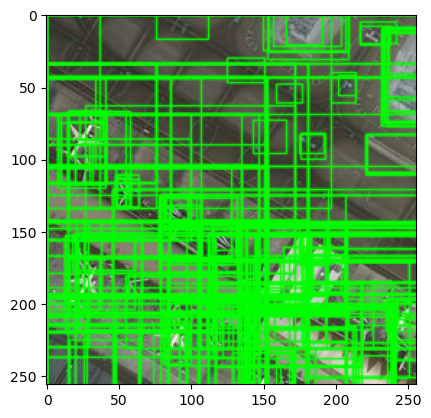

In [4]:
im = cv2.imread(os.path.join(images, "42845.jpg"))
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

# Intersection over Union (IoU) Calculation

In [6]:
def calculate_iou(box1, box2):
    if box1['x1'] >= box1['x2'] or box1['y1'] >= box1['y2']:
        raise ValueError("Invalid coordinates for box1")
    if box2['x1'] >= box2['x2'] or box2['y1'] >= box2['y2']:
        raise ValueError("Invalid coordinates for box2")

    x_overlap_start = max(box1['x1'], box2['x1'])
    y_overlap_start = max(box1['y1'], box2['y1'])
    x_overlap_end = min(box1['x2'], box2['x2'])
    y_overlap_end = min(box1['y2'], box2['y2'])

    if x_overlap_end < x_overlap_start or y_overlap_end < y_overlap_start:
        return 0.0

    intersection_area = (x_overlap_end - x_overlap_start) * (y_overlap_end - y_overlap_start)
    box1_area = (box1['x2'] - box1['x1']) * (box1['y2'] - box1['y1'])
    box2_area = (box2['x2'] - box2['x1']) * (box2['y2'] - box2['y1'])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    if iou < 0.0 or iou > 1.0:
        raise ValueError("IoU calculation error: IoU out of bounds")

    return iou

In [6]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
X_train = []
Y_train = []
airplanes = [
    annotation for annotation in os.listdir(annotations)
    if annotation.startswith("airplane")
]
for airplane in airplanes:
    filename = airplane.split(".")[0] + ".jpg"
    print(f'Processing {filename}...', end="")
    image = cv2.imread(os.path.join(images, filename))
    df = pd.read_csv(os.path.join(annotations, airplane))
    ground_truth_values = []

    for _, row in df.iterrows():
        ground_truth_values.append({
            "x1": int(row.iloc[0].split(" ")[0]),
            "x2": int(row.iloc[0].split(" ")[2]),
            "y1": int(row.iloc[0].split(" ")[1]),
            "y2": int(row.iloc[0].split(" ")[3])
        })

    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    results = ss.process()
    results = results[:1000]
    imout = image.copy()
    counter = 0
    falsecounter = 0
    flag = False
    fflag = False
    bflag = False

    for e, result in enumerate(results):
        for ground_truth_value in ground_truth_values:
            x, y, w, h = result
            iou = calculate_iou(ground_truth_value, {"x1": x, "x2": x + w, "y1": y, "y2": y + h})

            if counter < 30:
                if iou > 0.70:
                    timage = imout[y:y+h, x:x+w]
                    resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                    X_train.append(resized)
                    Y_train.append(1)
                    counter += 1
            else:
                fflag = True

            if falsecounter < 30:
                if iou < 0.3:
                    timage = imout[y:y+h, x:x+w]
                    resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                    X_train.append(resized)
                    Y_train.append(0)
                    falsecounter += 1
            else:
                bflag = True

        if fflag and bflag:
            print("Inside!")
            flag = True
            break
    if not flag:
      print("Outside!")

Processing airplane_489.jpg...Outside!
Processing airplane_304.jpg...Outside!
Processing airplane_462.jpg...Outside!
Processing airplane_476.jpg...Outside!
Processing airplane_310.jpg...Outside!
Processing airplane_338.jpg...Inside!
Processing airplane_660.jpg...Outside!
Processing airplane_106.jpg...Outside!
Processing airplane_112.jpg...Inside!
Processing airplane_674.jpg...Outside!
Processing airplane_648.jpg...Outside!
Processing airplane_099.jpg...Outside!
Processing airplane_072.jpg...Outside!
Processing airplane_066.jpg...Outside!
Processing airplane_700.jpg...Outside!
Processing airplane_270.jpg...Outside!
Processing airplane_516.jpg...Outside!
Processing airplane_502.jpg...Outside!
Processing airplane_264.jpg...Inside!
Processing airplane_258.jpg...Outside!
Processing airplane_259.jpg...Outside!
Processing airplane_503.jpg...Outside!
Processing airplane_265.jpg...Outside!
Processing airplane_271.jpg...Outside!
Processing airplane_517.jpg...Outside!
Processing airplane_067.jpg.

In [7]:
X_new = np.array(X_train)
y_new = np.array(Y_train)

In [8]:
vggmodel = VGG16(weights='imagenet', include_top=True)
for layers in (vggmodel.layers)[:15]:
    layers.trainable = False

In [11]:
X = vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)

In [12]:
model_final = Model(
    inputs=vggmodel.input,
    outputs=predictions
)
optimizer = Adam(learning_rate=0.0001)
model_final.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=optimizer,
    metrics=["accuracy"]
)


In [13]:
class CustomLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [14]:
lenc = CustomLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [15]:
X_train, X_test , y_train, y_test = train_test_split(X_new, Y, test_size=0.10)

In [16]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    'model_best.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

hist = model_final.fit(
    x=traindata,
    steps_per_epoch=10,
    epochs=10,
    validation_data=testdata,
    validation_steps=2,
    callbacks=[checkpoint, early_stopping]
)

/Users/foad/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6802 - loss: 1.3958 
Epoch 1: val_loss improved from inf to 0.42212, saving model to model_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 131s 13s/step - accuracy: 0.6851 - loss: 1.3710 - val_accuracy: 0.7969 - val_loss: 0.4221
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8361 - loss: 0.3579 
Epoch 2: val_loss improved from 0.42212 to 0.37265, saving model to model_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 121s 12s/step - accuracy: 0.8368 - loss: 0.3588 - val_accuracy: 0.7969 - val_loss: 0.3727
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8787 - loss: 0.3151 
Epoch 3: val_loss improved from 0.37265 to 0.29722, saving model to model_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 162s 17s/step - accuracy: 0.8792 - loss: 0.3113 - val_accuracy: 0.8906 - val_loss: 0.2972
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8973 - loss: 0.2771 
Epoch 4: val_loss improved from 0.29722 to 0.11867, saving

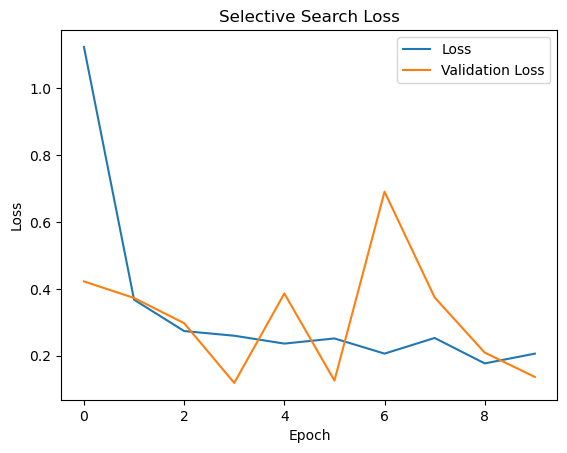

In [19]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Selective Search Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])
plt.show()

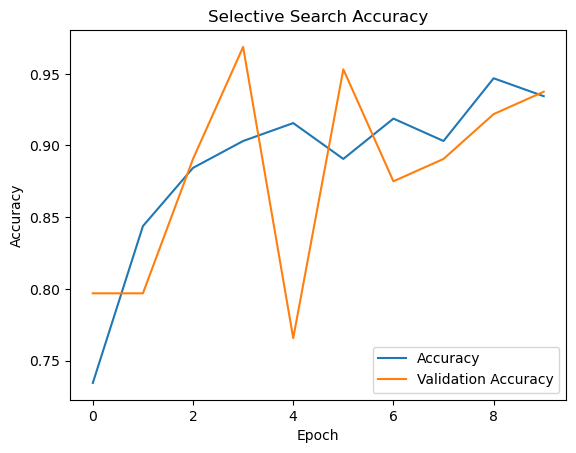

In [20]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Selective Search Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

## Alternative Way: Faster R-CNN Pre-Trained Model

In [3]:
class AirplaneDataset(Dataset):
    def __init__(self, dataset_pairs, transforms=None):
        self.dataset_pairs = dataset_pairs
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset_pairs)

    def __getitem__(self, idx):
        image_path, annotation_path = self.dataset_pairs[idx]
        img = Image.open(image_path).convert("RGB")
        annotation = pd.read_csv(annotation_path, header=None)
        
        num_airplanes = int(annotation.iloc[0, 0])
        boxes = []
        
        if num_airplanes > 0:
            for _, row in annotation.iloc[1:].iterrows():
                coords = list(map(int, row.iloc[0].split()))
                if len(coords) == 4:
                    xmin, ymin, xmax, ymax = coords
                    boxes.append([xmin, ymin, xmax, ymax])
        
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.ones((len(boxes),), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels
        }
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, target

image_files = {os.path.splitext(os.path.basename(f))[0]: f for f in glob.glob(f'{images}/*.jpg')}
annotation_files = {os.path.splitext(os.path.basename(f))[0]: f for f in glob.glob(f'{annotations}/*.csv')}
valid_pairs = set(image_files.keys()).intersection(set(annotation_files.keys()))
dataset_pairs = [(image_files[k], annotation_files[k]) for k in valid_pairs]

valid_dataset_pairs = []
for image_path, annotation_path in dataset_pairs:
    annotation = pd.read_csv(annotation_path, header=None)
    num_airplanes = int(annotation.iloc[0, 0])
    
    if num_airplanes > 0:
        valid_dataset_pairs.append((image_path, annotation_path))

## Data Loader

In [5]:
def collate_fn(batch):
    images = []
    targets = []
    
    for img, tgt in batch:
        images.append(img)
        targets.append(tgt)
    
    return images, targets


dataset_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_pairs, test_pairs = train_test_split(
    valid_dataset_pairs, 
    test_size=0.2, 
    random_state=42
)

dataset_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = AirplaneDataset(train_pairs, transforms=dataset_transforms)
test_dataset = AirplaneDataset(test_pairs, transforms=dataset_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

## Faster R-CNN Pre-Trained Model

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2)

device = torch.device('cpu')
model.to(device)
print(f'Using device: {device}')

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Training

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
    
    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Average Loss: {train_loss:.4f}")
    lr_scheduler.step()

Epoch 1 Training:   0%|          | 0/146 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/foad/miniconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/foad/miniconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'AirplaneDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Epoch 1 Training:   0%|          | 0/146 [00:04<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 83189) exited unexpectedly

## Evaluation

In [ ]:
model.eval()
image_precisions = []
image_recalls = []
image_f1s = []
image_ious = []
iou_threshold = 0.5

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        outputs = model(images)
        
        for output, target in zip(outputs, targets):
            pred_boxes = output['boxes']
            gt_boxes = target['boxes']
            
            if len(pred_boxes) == 0 and len(gt_boxes) == 0:
                image_precisions.append(1.0)
                image_recalls.append(1.0)
                image_f1s.append(1.0)
                image_ious.append(1.0)
                continue
            
            if len(pred_boxes) == 0:
                image_precisions.append(0.0)
                image_recalls.append(0.0)
                image_f1s.append(0.0)
                image_ious.append(0.0)
                continue
            
            if len(gt_boxes) == 0:
                image_precisions.append(0.0)
                image_recalls.append(0.0)
                image_f1s.append(0.0)
                image_ious.append(0.0)
                continue
            
            iou = box_iou(pred_boxes, gt_boxes)
            matched_preds = (iou.max(dim=1)[0] > iou_threshold).int().cpu().numpy()
            matched_gts = (iou.max(dim=0)[0] > iou_threshold).int().cpu().numpy()
            
            precision = np.sum(matched_preds) / len(pred_boxes.cpu().numpy())
            recall = np.sum(matched_gts) / len(gt_boxes.cpu().numpy())
            f1 = (
                2 * precision * recall / (precision + recall)
                if precision + recall > 0 else 0.0
            )
            avg_iou = iou.mean().item()
            
            image_precisions.append(precision)
            image_recalls.append(recall)
            image_f1s.append(f1)
            image_ious.append(avg_iou)


metrics = {
    'Average Precision': np.mean(image_precisions),
    'Average Recall': np.mean(image_recalls),
    'Average F1-Score': np.mean(image_f1s),
    'Average IoU': np.mean(image_ious)
}

print("\nEvaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")